# Learning to make a market with competition

### Import external modules

In [1]:
import gym
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor

from labellines import labelLine, labelLines

In [2]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
%config InlineBackend.figure_format = "retina"
resolution_value = 100

In [3]:
%load_ext autoreload
%autoreload 2

### Add mbt-gym to path

In [4]:
import sys
sys.path.append("../")

In [5]:
from mbt_gym.gym.index_names import TIME_INDEX, INVENTORY_INDEX, COMPETITION_STATE_INDEX

from mbt_gym.agents.BaselineAgents import CarteaJaimungalMmAgent
from mbt_gym.gym.helpers.generate_trajectory import generate_trajectory
from mbt_gym.gym.StableBaselinesTradingEnvironment import StableBaselinesTradingEnvironment
from mbt_gym.gym.TradingEnvironment import TradingEnvironment
from mbt_gym.gym.wrappers import *
from mbt_gym.rewards.RewardFunctions import PnL, CjMmCriterion, BhsbMmCriterion
from mbt_gym.stochastic_processes.midprice_models import BrownianMotionMidpriceModel
from mbt_gym.stochastic_processes.arrival_models import PoissonArrivalModel
from mbt_gym.stochastic_processes.competition_inventory import BhsbInventoryModel
from mbt_gym.stochastic_processes.fill_probability_models import ExponentialFillFunction, CompetitionFillFunction
from mbt_gym.gym.ModelDynamics import LimitOrderModelDynamics, CompetitionLimitOrderModelDynamics

### Create market making environment

In [6]:
terminal_time = 1.0
bid_arrival_rate = 10.0
ask_arrival_rate = 10.0
n_steps = int(10 * terminal_time * np.maximum(bid_arrival_rate,ask_arrival_rate))
phi = 0.1
alpha = 0.001
beta = 0.1
sigma_z = 2.
sigma_s = 2.
S0 = 100
qmin = -10
qmax = 10
kappa = 2.
tick_size = 0.001

In [7]:
def get_bhsb_env(num_trajectories:int = 1):
    initial_inventory = 0 #(-4,5)
    fill_exponent = kappa
    initial_price = S0
    step_size = 1/n_steps
    timestamps = np.linspace(0, terminal_time, n_steps + 1)
    midprice_model = BrownianMotionMidpriceModel(volatility=sigma_s, step_size=1/n_steps,
                                                 num_trajectories=num_trajectories)
    arrival_model = PoissonArrivalModel(intensity=np.array([ask_arrival_rate, bid_arrival_rate]), 
                                        step_size=1/n_steps, 
                                        num_trajectories=num_trajectories)
    fill_probability_model = CompetitionFillFunction(fill_exponent=fill_exponent, 
                                                     step_size=1/n_steps,
                                                     num_trajectories=num_trajectories, tick_size= tick_size)
    competition_inventory_model = BhsbInventoryModel(min_value_inventory = -qmin,
                                            max_value_inventory = qmax,
                                            alpha = alpha,
                                            beta = beta,
                                            step_size = 1/n_steps,
                                            sigma = sigma_z,
                                            num_trajectories = num_trajectories)
    LOtrader = CompetitionLimitOrderModelDynamics(midprice_model = midprice_model, arrival_model = arrival_model, 
                                fill_probability_model = fill_probability_model,
                                competition_inventory_model = competition_inventory_model,
                                num_trajectories = num_trajectories,
                                max_depth = 4.,
                                min_depth = -3.)
    reward_function = BhsbMmCriterion(per_step_inventory_aversion = phi, terminal_inventory_aversion = alpha,
                                     beta = beta, sigma = sigma_z)
    env_params = dict(terminal_time=terminal_time, 
                      n_steps=n_steps,
                      initial_inventory = initial_inventory,
                      model_dynamics = LOtrader,
                      max_inventory=qmax,
                      normalise_action_space = False,
                      normalise_observation_space = False,
                      reward_function = reward_function,
                      num_trajectories=num_trajectories)
    return TradingEnvironment(**env_params)

In [8]:
num_trajectories = 10000
env = ReduceStateSizeWrapper(env = get_bhsb_env(num_trajectories), list_of_state_indices = [INVENTORY_INDEX, TIME_INDEX, COMPETITION_STATE_INDEX, COMPETITION_STATE_INDEX+1])

In [9]:
sb_env = StableBaselinesTradingEnvironment(trading_env=env)

In [10]:
# Monitor sb_env
sb_env = VecMonitor(sb_env)
# Add directory for tensorboard logging and best model
tensorboard_logdir = "./tensorboard/PPO-learning-CJ/"
best_model_path = "./SB_models/PPO-best-CJ"

### Define PPO policy

In [11]:
policy_kwargs = dict(net_arch=[dict(pi=[256, 256], vf=[256, 256])])
PPO_params = {"policy":'MlpPolicy', "env": sb_env, "verbose":1, 
              "policy_kwargs":policy_kwargs, 
              "tensorboard_log":tensorboard_logdir,
              "n_epochs":3,
              "batch_size": int(n_steps * num_trajectories / 10), 
              "n_steps": int(n_steps)}
callback_params = dict(eval_env=sb_env, n_eval_episodes = 2048, #200 before  (n_eval_episodes)
                       best_model_save_path = best_model_path, 
                       deterministic=True)

callback = EvalCallback(**callback_params)
model = PPO(**PPO_params, device="cpu")

Using cpu device


In [12]:
model.learn(total_timesteps = 100_000_000)  # Increase number of training timesteps according to computing resources

Logging to ./tensorboard/PPO-learning-CJ/PPO_26
-----------------------------------
| rollout/           |            |
|    ep_len_mean     | 100        |
|    ep_rew_mean     | -6.9846344 |
| time/              |            |
|    fps             | 724760     |
|    iterations      | 1          |
|    time_elapsed    | 1          |
|    total_timesteps | 1000000    |
-----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -7.989701    |
| time/                   |              |
|    fps                  | 203917       |
|    iterations           | 2            |
|    time_elapsed         | 9            |
|    total_timesteps      | 2000000      |
| train/                  |              |
|    approx_kl            | 0.0043221656 |
|    clip_fraction        | 0.0215       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -1.0937718   |
| time/                   |              |
|    fps                  | 126242       |
|    iterations           | 11           |
|    time_elapsed         | 87           |
|    total_timesteps      | 11000000     |
| train/                  |              |
|    approx_kl            | 0.0045380243 |
|    clip_fraction        | 0.029        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.66        |
|    explained_variance   | 0.14         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.818        |
|    n_updates            | 30           |
|    policy_gradient_loss | -0.00168     |
|    std                  | 0.908        |
|    value_loss           | 1.64         |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | 1.0281336    |
| time/                   |              |
|    fps                  | 122344       |
|    iterations           | 20           |
|    time_elapsed         | 163          |
|    total_timesteps      | 20000000     |
| train/                  |              |
|    approx_kl            | 0.0029814593 |
|    clip_fraction        | 0.0125       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.49        |
|    explained_variance   | 0.00597      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.422        |
|    n_updates            | 57           |
|    policy_gradient_loss | -0.000843    |
|    std                  | 0.836        |
|    value_loss           | 0.835        |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | 1.3419468    |
| time/                   |              |
|    fps                  | 121362       |
|    iterations           | 29           |
|    time_elapsed         | 238          |
|    total_timesteps      | 29000000     |
| train/                  |              |
|    approx_kl            | 0.0013238669 |
|    clip_fraction        | 0.00177      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.35        |
|    explained_variance   | 0.0829       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.259        |
|    n_updates            | 84           |
|    policy_gradient_loss | -0.000148    |
|    std                  | 0.781        |
|    value_loss           | 0.521        |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | 1.2510077    |
| time/                   |              |
|    fps                  | 121213       |
|    iterations           | 38           |
|    time_elapsed         | 313          |
|    total_timesteps      | 38000000     |
| train/                  |              |
|    approx_kl            | 0.0015354577 |
|    clip_fraction        | 0.00281      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.23        |
|    explained_variance   | 0.108        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.25         |
|    n_updates            | 111          |
|    policy_gradient_loss | -0.000142    |
|    std                  | 0.736        |
|    value_loss           | 0.503        |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | 2.308274     |
| time/                   |              |
|    fps                  | 121208       |
|    iterations           | 47           |
|    time_elapsed         | 387          |
|    total_timesteps      | 47000000     |
| train/                  |              |
|    approx_kl            | 0.0009576902 |
|    clip_fraction        | 0.00249      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.11        |
|    explained_variance   | 0.123        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.26         |
|    n_updates            | 138          |
|    policy_gradient_loss | -0.00015     |
|    std                  | 0.691        |
|    value_loss           | 0.522        |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | 1.7298242    |
| time/                   |              |
|    fps                  | 121127       |
|    iterations           | 56           |
|    time_elapsed         | 462          |
|    total_timesteps      | 56000000     |
| train/                  |              |
|    approx_kl            | 0.0012045363 |
|    clip_fraction        | 0.00308      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.98        |
|    explained_variance   | 0.139        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.264        |
|    n_updates            | 165          |
|    policy_gradient_loss | -4.38e-05    |
|    std                  | 0.649        |
|    value_loss           | 0.519        |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | 2.0082006    |
| time/                   |              |
|    fps                  | 121221       |
|    iterations           | 65           |
|    time_elapsed         | 536          |
|    total_timesteps      | 65000000     |
| train/                  |              |
|    approx_kl            | 0.0010792561 |
|    clip_fraction        | 0.00336      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.85        |
|    explained_variance   | 0.166        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.255        |
|    n_updates            | 192          |
|    policy_gradient_loss | -0.000111    |
|    std                  | 0.609        |
|    value_loss           | 0.506        |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | 2.0183213    |
| time/                   |              |
|    fps                  | 121222       |
|    iterations           | 74           |
|    time_elapsed         | 610          |
|    total_timesteps      | 74000000     |
| train/                  |              |
|    approx_kl            | 0.0015555266 |
|    clip_fraction        | 0.00339      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.73        |
|    explained_variance   | 0.181        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.26         |
|    n_updates            | 219          |
|    policy_gradient_loss | -2.83e-05    |
|    std                  | 0.574        |
|    value_loss           | 0.522        |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | 2.0417817    |
| time/                   |              |
|    fps                  | 121048       |
|    iterations           | 83           |
|    time_elapsed         | 685          |
|    total_timesteps      | 83000000     |
| train/                  |              |
|    approx_kl            | 0.0013094565 |
|    clip_fraction        | 0.00274      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.61        |
|    explained_variance   | 0.192        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.275        |
|    n_updates            | 246          |
|    policy_gradient_loss | -0.000109    |
|    std                  | 0.539        |
|    value_loss           | 0.556        |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | 2.1330984    |
| time/                   |              |
|    fps                  | 120942       |
|    iterations           | 92           |
|    time_elapsed         | 760          |
|    total_timesteps      | 92000000     |
| train/                  |              |
|    approx_kl            | 0.0008233322 |
|    clip_fraction        | 0.00277      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.49        |
|    explained_variance   | 0.201        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.302        |
|    n_updates            | 273          |
|    policy_gradient_loss | -1.66e-05    |
|    std                  | 0.508        |
|    value_loss           | 0.601        |
------------------------------------------
------------------------------------------
| rollout/ 

In [13]:
model.save("PPO-learning-pooledcomp")

## Comparing the learnt policy to the optimal policy

In [14]:
from mbt_gym.agents.SbAgent import SbAgent

In [15]:
model = PPO.load("PPO-learning-pooledcomp")

In [16]:
ppo_agent = SbAgent(model, num_trajectories=10_000)

In [17]:
inventories = np.arange(-3,4,1)
bid_actions = []
ask_actions = []
for inventory in inventories:
    bid_action, ask_action = ppo_agent.get_action(np.array([[inventory,0.5, 0, 0]])).reshape(-1)
    bid_actions.append(bid_action)
    ask_actions.append(ask_action)    

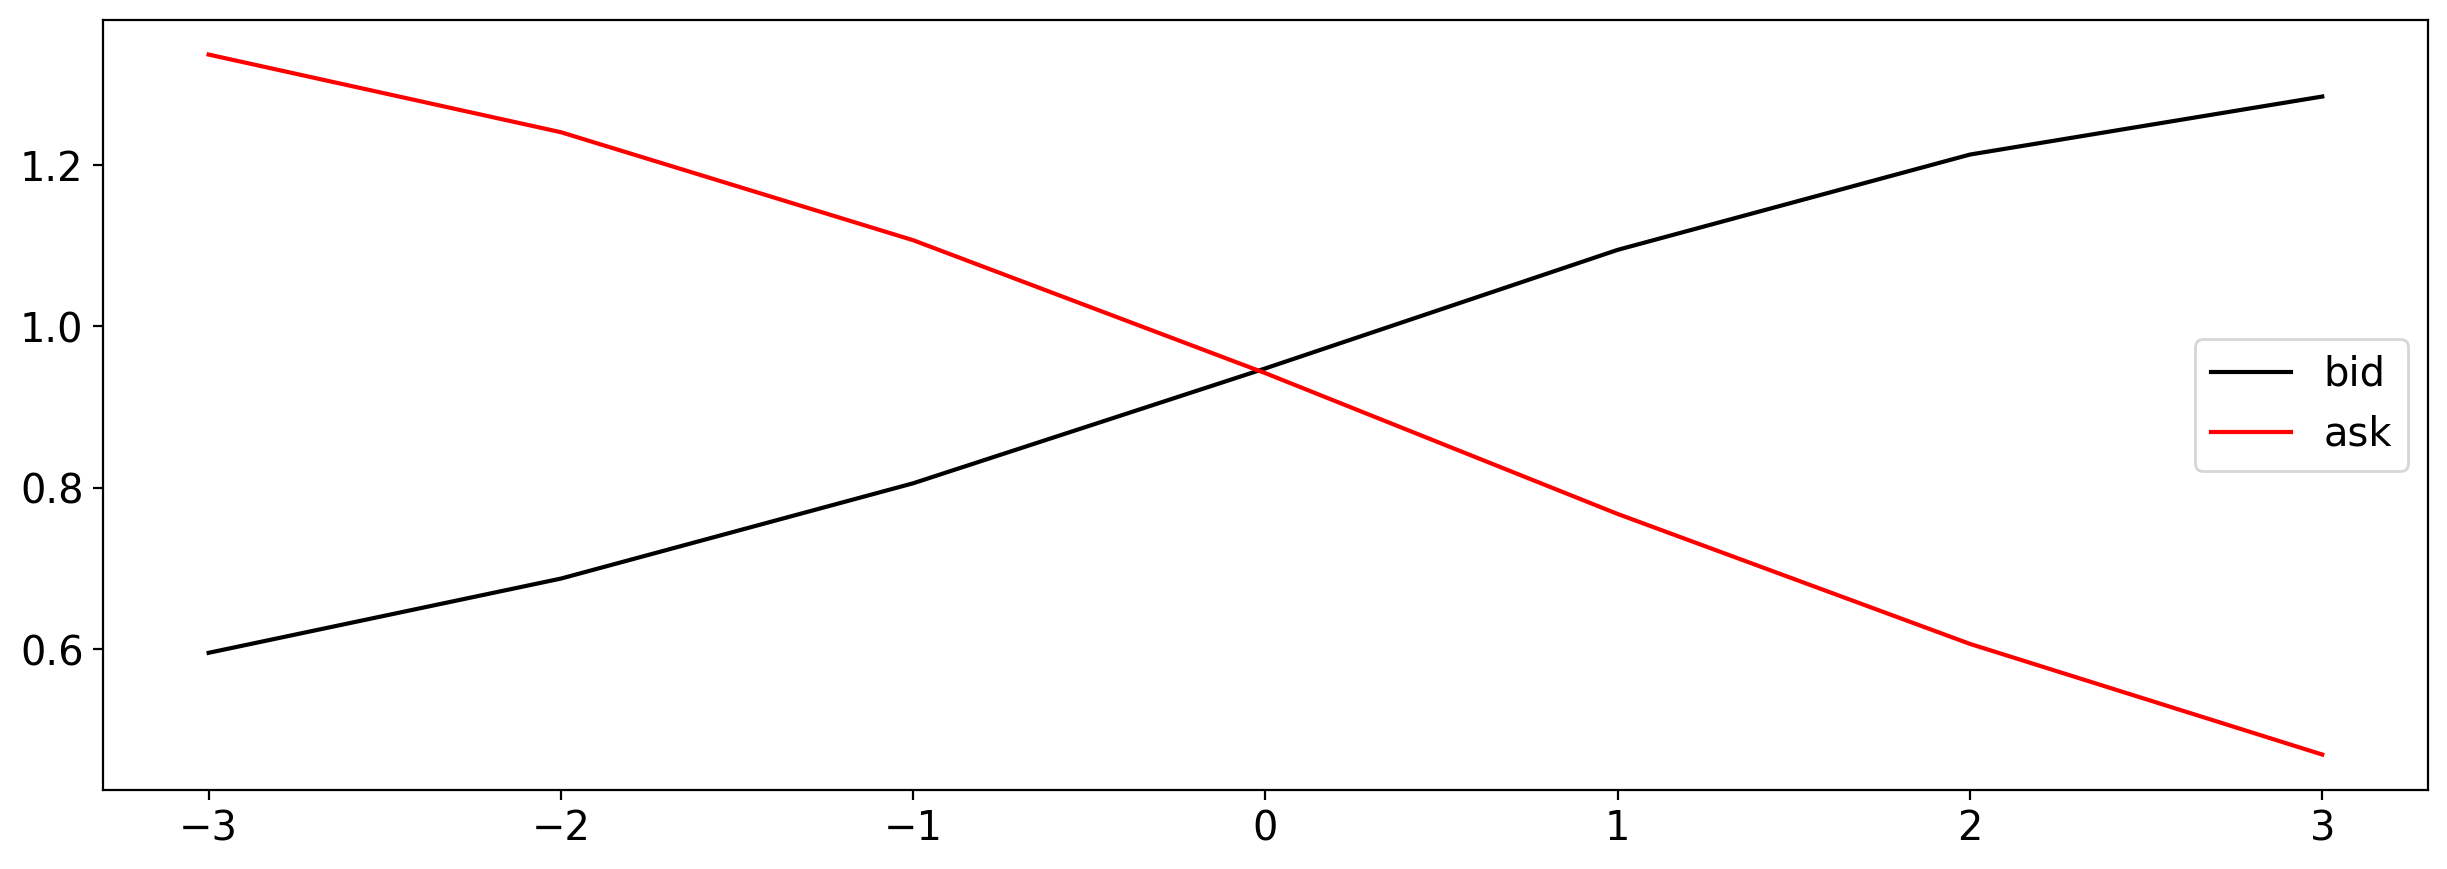

In [18]:
plt.plot(inventories, bid_actions, label = "bid", color = "k")
plt.plot(inventories, ask_actions, label = "ask", color = "r")
plt.legend()

In [19]:
inventories = np.arange(-3,4,1)
len(inventories)
print(inventories)

[-3 -2 -1  0  1  2  3]


In [20]:
inventories = np.arange(-5,6,1)
comp_inventories = np.arange(-9,10,1)

bid_actions = np.zeros((len(inventories),len(comp_inventories)))
ask_actions = np.zeros((len(inventories),len(comp_inventories)))
for iq, inventory in enumerate(inventories):
    for iqc, comp_inventory in enumerate(comp_inventories):
        bid_action, ask_action = ppo_agent.get_action(np.array([[inventory,0.5, comp_inventory, 0]])).reshape(-1)
        bid_actions[iq,iqc] = bid_action
        ask_actions[iq,iqc] = ask_action

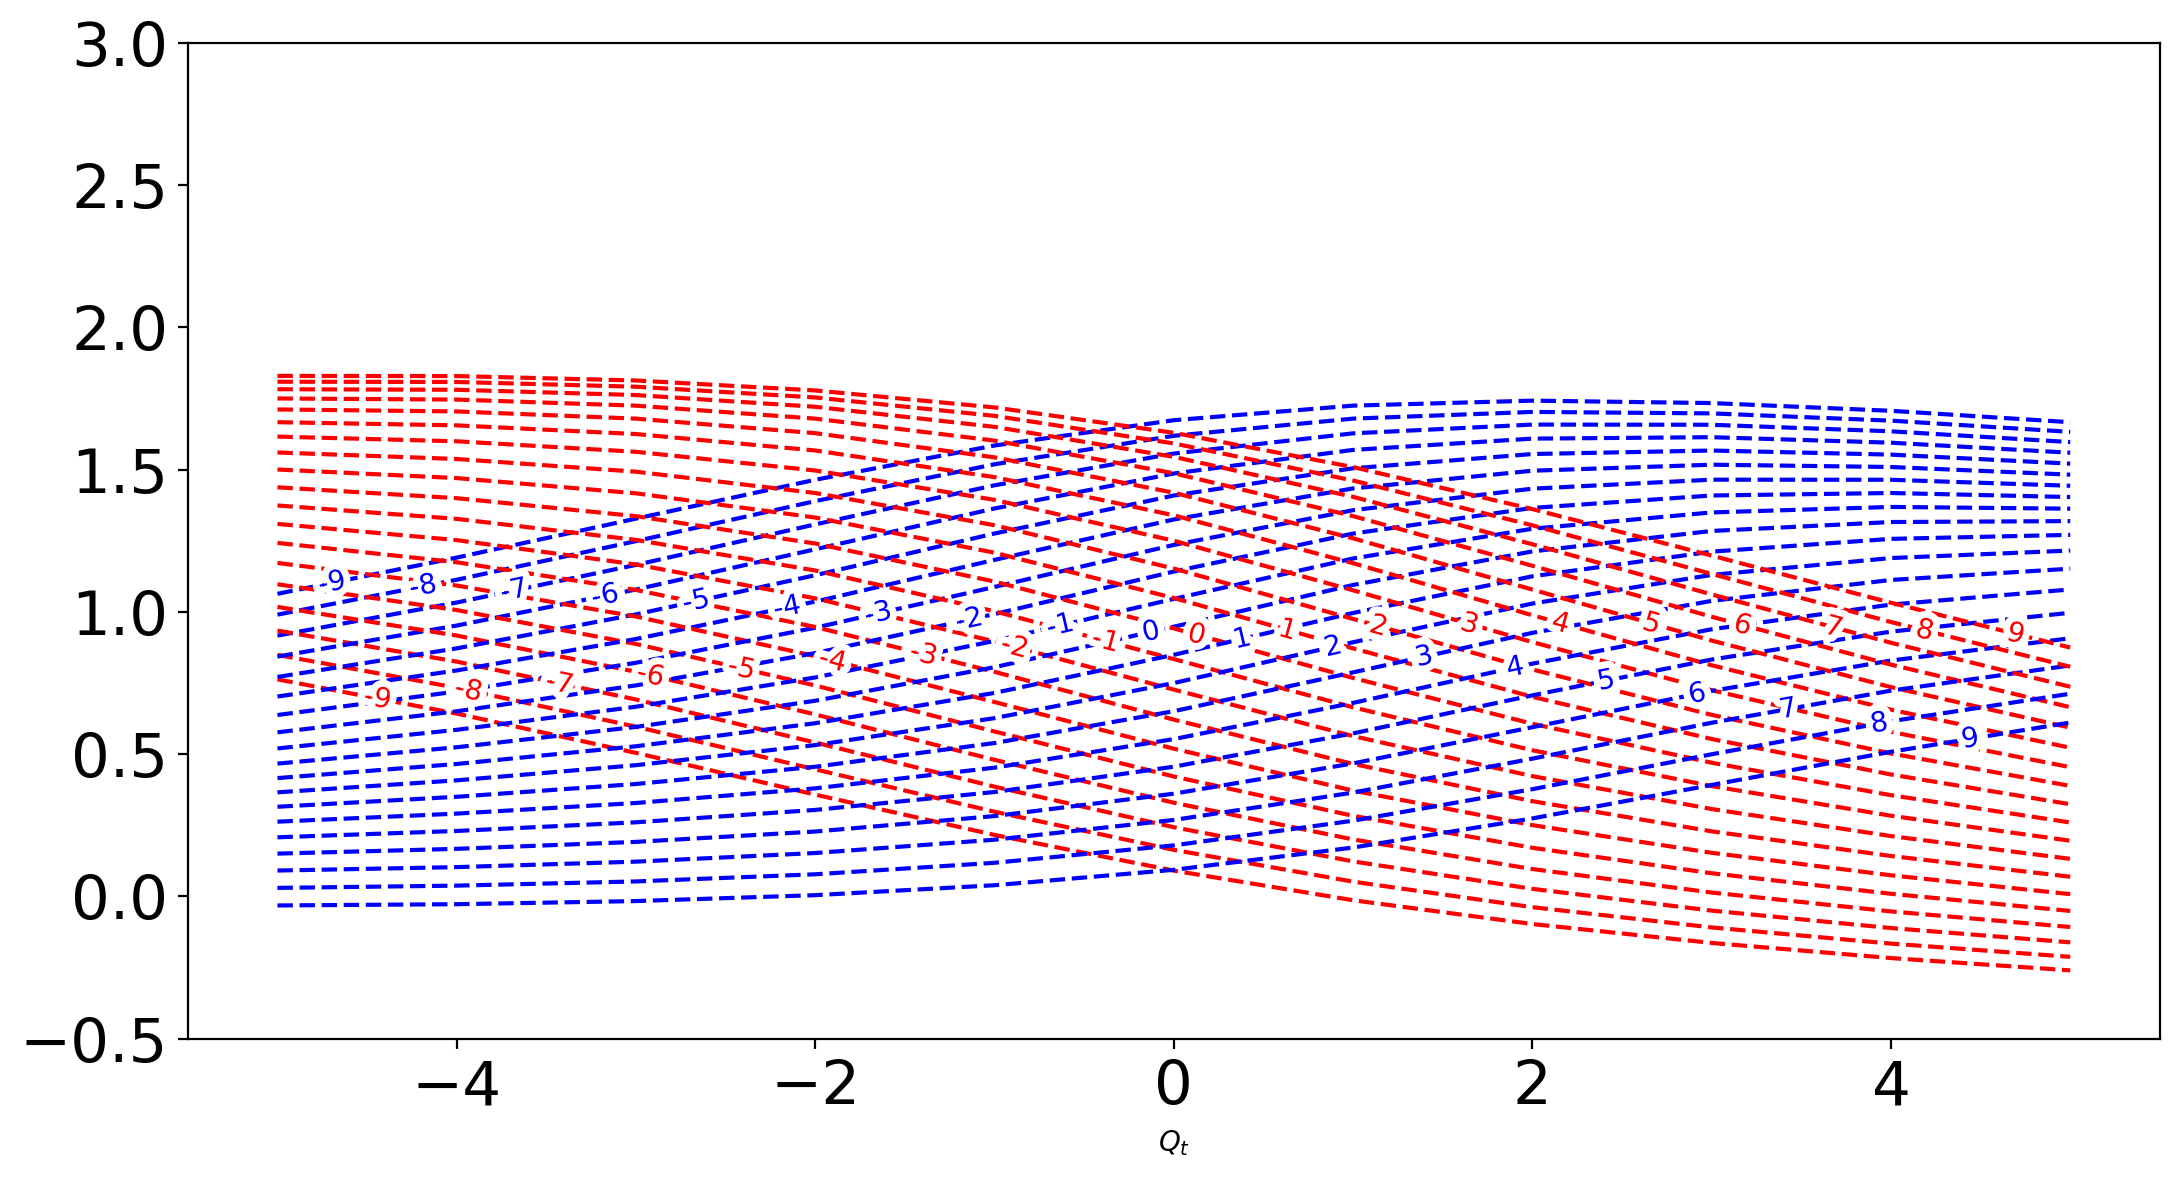

In [21]:
fig, ax = plt.subplots(1,1, figsize = (11,6), sharey=True)
for iqc, comp_inventory in enumerate(comp_inventories):
    ax.plot(inventories, bid_actions[:,iqc], 'b--', label = str(comp_inventory))
    ax.plot(inventories, ask_actions[:,iqc], 'r--', label = str(comp_inventory))
labelLines(ax.get_lines(), zorder=2.5)
plt.ylim(-0.5,3)
plt.xlabel(r'$Q_t$')
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
plt.tight_layout()
plt.savefig('figures/learntdepths.pdf', format="pdf", dpi=resolution_value)
plt.show()

In [22]:

from mbt_gym.agents.SbAgent import SbAgent
from mbt_gym.gym.helpers.generate_trajectory import generate_trajectory


In [23]:
trained_agent = SbAgent(model, num_trajectories=10_000)

In [24]:
# step 1: evaluate
observations, actions, rewards = generate_trajectory(sb_env, trained_agent)
# results, fig, total_rewards = generate_results_table_and_hist(big_env, trained_agent)

In [25]:
total_rewards = rewards.sum(axis=-1).reshape(-1)
print(np.mean(total_rewards))
print(np.std(total_rewards))

2.846093385462577
2.6033035867591443
